# EIMS Data
This script will read in the individual EIMS data files from the given directory and compile/prase the data for the model.

In [1]:
## Install the package if needed:
#install.packages('geosphere', repos='http://cran.us.r-project.org')

## Load the relevent packages
library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)
#library(lattice)
#library(geosphere)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='GMT') {
    as.POSIXct(as.Date(x, origin="1899-12-30", tz=tz))
}

conv_roms_time = function(x, tz='UTC') {
    as.POSIXct(x, origin="1900-01-01")
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(9, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 3

# File Input

First we need to set the directory and file name criteria of the data to load. We also set the date-time format that the parser will be expecting.

In [21]:
input.dir = './Raw Data/EIMS/'
dt.format = "%m/%d/%y %I:%M %p"

## Generate list of files in the directory
file.list = list.files(input.dir)

## split file.list into usable lists
file.list.nu = file.list[grepl('not usable', file.list)] # not usable
file.list.2 = file.list[grepl('corr.txt', file.list)] # usable

## Print total number of files in each category
print(paste('Number of files in file.list:', length(file.list)))
print(paste('Number of files in file.list.2:', length(file.list.2)))
print(paste('Number of files in file.list.nu:', length(file.list.nu)))


[1] "Number of files in file.list: 176"
[1] "Number of files in file.list.2: 67"
[1] "Number of files in file.list.nu: 5"


In [22]:
## Read in first data file and configure formatting around it
data = read.csv(paste0(input.dir, file.list.2[1]), sep='\t')
data$time = strptime(data$time, format = dt.format, tz='GMT')

# Main Functions

These functions will do the heavy lifting for the EIMS preparation. The __avg.eims()__ generates the average of N minutes of samples while __filter.eims()__ goes QC type of work by removing high/low pressure samples and handles missing values.

In [23]:
## Average
avg.eims = function(x, N) {
    i = 1
    x = x[x$Flag == 1,] # Only want Accept Flags
    
    while (i < nrow(x)) {
        dt = as.numeric(difftime(x$time, x$time[i], unit='mins'))
        l = which(dt >= 0 & dt < N)
        
        ## Calculate the mean of the relevant columns, removing na's
        x[i, 3:ncol(x)] = apply(x[l, 3:ncol(x)], 2, function(x) {mean(x, na.rm = TRUE)})
    
        if (length(l) > 1) {
            l = l[l != i]
            if (length(l) > 30) {
                x = x[-l,]
            } else if (length(l) > 0) {
                x = x[-l,]
            }
        }
        i = i + 1
    }
    x
}

## Prepare filter function
filter.eims = function(x) {
    x$Flag = 1
    
    ## Remove entries where flow not within 5% of 100
    x$Flag[x$flow > 105 | x$flow < 95] = 3 # Reject
    x$Flag[x$O2.Ar > 35 | x$O2.Ar < 22] = 3 # Reject
    
    ## Remove first minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[1], unit='mins'))^2 < 1)
    x$Flag[l] = 3 # Reject
    
    ## Remove last minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[nrow(x)], unit='mins'))^2 < 1)
    x$Flag[l] = 3 # Reject
    
    ## find all valve switches and remove all entries within a miute of it.
    l = which(diff(x$Valve) != 0)
    for (i in l) {
        dt = abs(as.numeric(difftime(x$time[i], x$time, unit='mins')))     
        x$Flag[which(dt <= 1)] = 3 # Reject
    }
    ## Remove NA O2Ar entries
    x$Flag[!is.na(x$O2.Ar)] = 3
    
    x$Flag[x$Valve == 2] = 2 # Calibration
    x$Flag[is.na(x$Valve)] = 3 # Reject unknown valve
    
    x
}

In [24]:
read.eims = function(valve = 1, input.dir, file.list, N = 2, verbose = FALSE, template = data, make.img = FALSE) {
    ## Create template data structure to add new entries to:
    data = template[1,] # valve = 1

    for (i in file.list) {
        
        #### load file and parse the time and filter the values
        data = read.csv(paste0(input.dir, i), sep='\t')
        data$time = strptime(data$time, format = dt.format, tz='GMT')
        data = filter.eims(data)
        
        if (make.img) {
            cols = c('black', 'orange', 'red')
    
            png(file = paste0('Output/EIMS/', i, '.png'))
            plot(data$time, data$O2.Ar, col=cols[data$Flag], pch=20, ylab='O2/Ar', xlab='', main=i, cex=0.2)
            dev.off()
        }
        
        ## Verbose
        if (verbose) { print(paste("Loaded file:", i)) }
        
        #### determine valve  
        l = which(data$Valve == valve)
        temp = avg.eims(data[l,], N)

        if (length(names(temp)) == length(names(data))) {
            ## Do the column names match?
            names(temp) = names(data) # Force colname match (dangerous), but will check that lengths are the same
            data = rbind(data, temp)
            
            if (verbose) { print(paste('  Added', nrow(temp),'to valve 1.')) }
            
        }
        else {warning(i)}
    }


    ## Remove the first row used to initiate the table
    data = data[-1,]
    data = data[,-c(13, 14, 15, 23, 24, 25)]
    
    data
}

## Run the parser
This will initialize the parser for valve = 1 (sampling) and then valve = 2 (calibration). Included in this is the ___filter.eims()___ and ___take.avg()___ functions.

__NB This will take a while...__

In [25]:
data.v1 = read.eims(1, input.dir, file.list.2, N = 2, verbose = FALSE, template = data, make.img = TRUE)
data.v2 = read.eims(2, input.dir, file.list.2, N = 20, verbose = FALSE, template = data, make.img = FALSE)

Warning message in png(file = paste0("Output/EIMS/", i, ".png")):
"unable to open file 'Output/EIMS/_2017-0604-0448 MID-TBK-valve corr.txt.png' for writing"Warning message in png(file = paste0("Output/EIMS/", i, ".png")):
"opening device failed"

ERROR: Error in png(file = paste0("Output/EIMS/", i, ".png")): unable to start png() device


In [20]:
## Also, correct the time since the year is not actually 2021...
data.v1$time = data.v1$time - 4 * 365.25 * 86400 - 86400
data.v2$time = data.v2$time - 4 * 365.25 * 86400 - 86400

## Remove NA O2:Ar values
data.v1 = data.v1[which(!is.na(data.v1$O2.Ar)),]
data.v2 = data.v2[which(!is.na(data.v2$O2.Ar)),]

## Number of entries, do they seem right?
nrow(data.v1)
nrow(data.v2)

ERROR: Error in eval(expr, envir, enclos): object 'data.v1' not found


In [27]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,580832,31.1,1770749,94.6,1770749,94.6
Vcells,2207123,16.9,29992100,228.9,37504054,286.2


## Review results

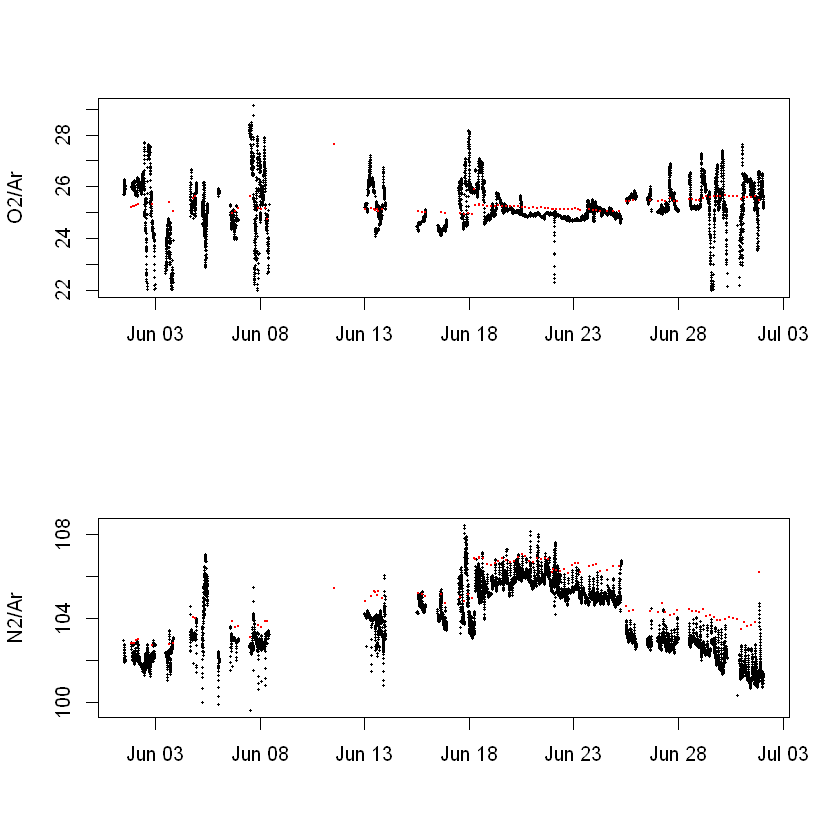

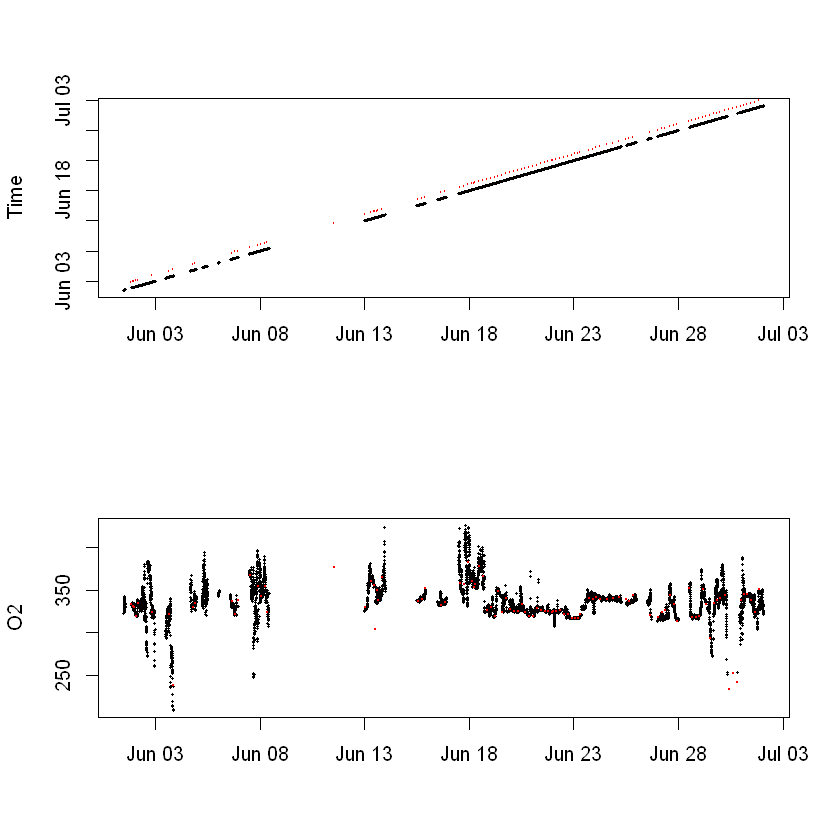

In [28]:
#pdf('./Output/Generate-EIMS-review1.pdf')

par(mfrow=c(2,1))
l = order(data.v1$time)
ll = order(data.v2$time)

plot(data.v1$time[l], data.v1$O2.Ar[l], pch=16, cex=0.3, ylab='O2/Ar', xlab='')
points(data.v2$time[ll], data.v2$O2.Ar[ll], pch=16, cex=0.2, col='red')

legend(data.v1$time[1], 19, c('Measurements', 'Calibration'), col=c('black', 'red'), pch=16, cex=0.6)

plot(data.v1$time[l], data.v1$N2.Ar[l], pch=16, cex=0.3, ylab='N2/Ar', xlab='')
points(data.v2$time[ll], data.v2$N2.Ar[ll], pch=16, cex=0.2, col='red')

plot(data.v1$time[l], data.v1$time[l], pch=16, cex=0.3, ylab='Time', xlab='')
points(data.v2$time[ll], data.v2$time[ll]+86400, cex=0.2, col='red')

plot(data.v1$time[l], data.v1$O2..uM.[l], pch=16, cex=0.3, ylab='O2', xlab='')
points(data.v2$time[ll], data.v2$O2..uM.[ll], pch=16, cex=0.2, col='red')

legend(data.v2$time[1], 470, c('Measurements', 'Calibration'), col=c('black', 'red'), pch=16, cex=0.6)

#dev.off()

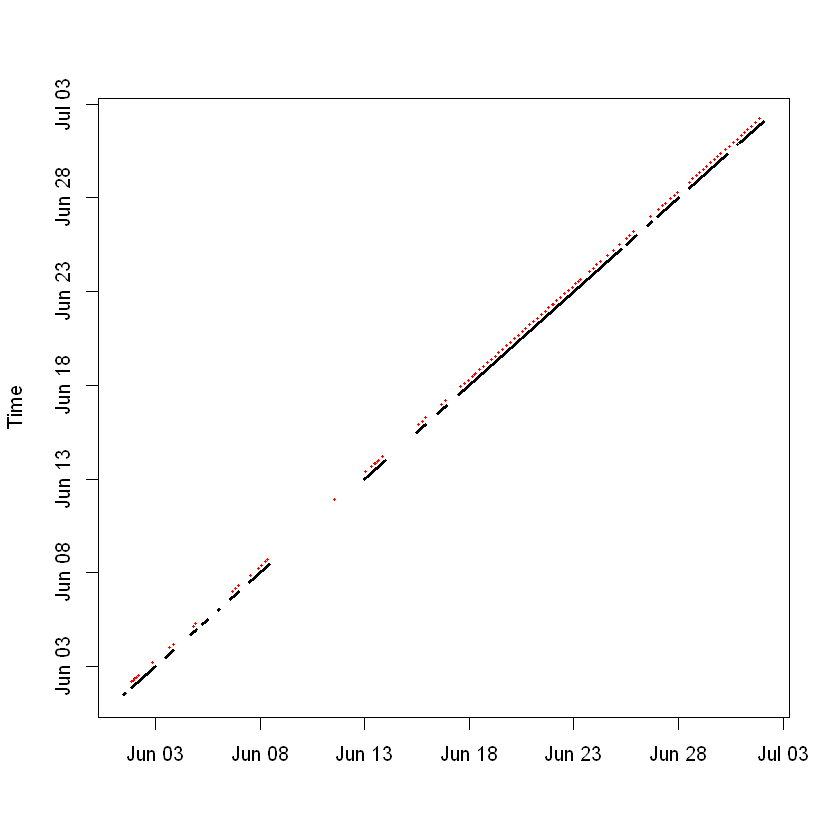

In [29]:
#pdf('./Output/Generate-EIMS-review2.pdf')

plot(data.v1$time[l], data.v1$time[l], pch=16, cex=0.3, ylab='Time', xlab='')
points(data.v2$time[ll], data.v2$time[ll]+86400/3, pch=16, cex=0.3, col='red')
legend(data.v1$time[1], data.v1$time[nrow(data.v1)], c('Measurements', 'Calibration'), col=c('black', 'red'), pch=16)

#dev.off()

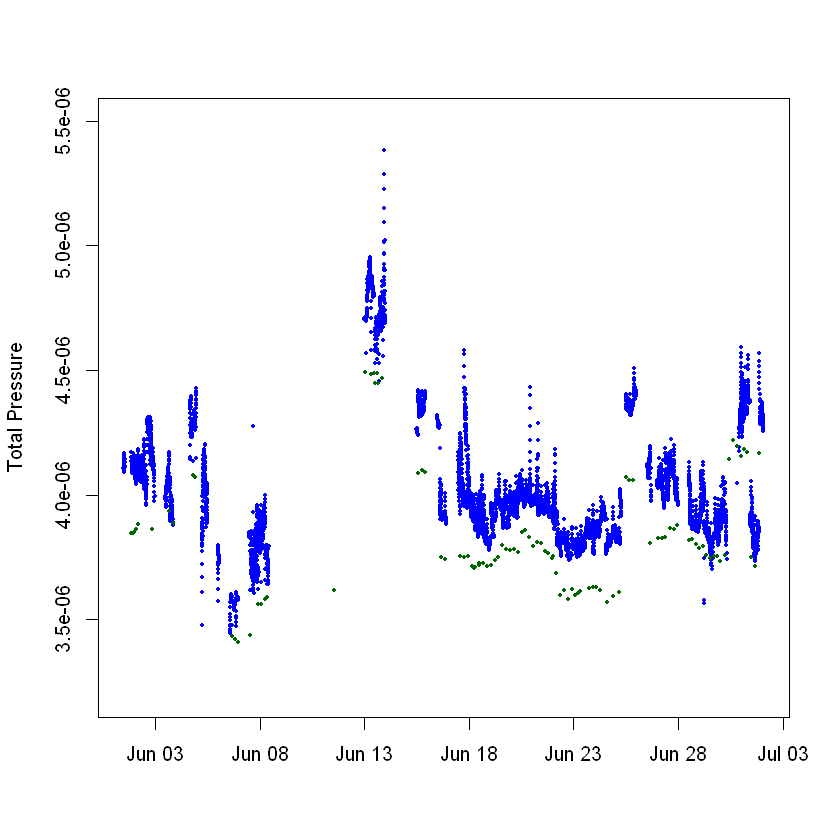

In [30]:
plot(data.v1$time, data.v1$TP, col='white', ylim=c(3.2e-6, 5.5e-6), ylab='Total Pressure', xlab='')

col = c('Black', 'blue', 'grey', 'dark green')

for (i in 1:length(unique(data.v1[,1]))) {
    l = which(data.v1[,1] == unique(data.v1[,1])[i])
    points(data.v1$time[l], data.v1$TP[l], col=col[i %% 2 + 1], pch=20, cex=0.6)
}

for (i in 1:length(unique(data.v2[,1]))) {
    l = which(data.v2[,1] == unique(data.v2[,1])[i])
    points(data.v2$time[l], data.v2$TP[l], col=col[i %% 2 + 3], pch=20, cex=0.6)
}


# Save

In [32]:
## Save the data
eims.v1 = data.v1
eims.v2 = data.v2
save(eims.v1, file='./RStates/EIMS.v1.2min.rdata')
save(eims.v2, file='./RStates/EIMS.v2.60min.rdata')

## Optional
write.csv(data.v1, './Input Data/EIMS-Valve1.2min.csv')
write.csv(data.v2, './Input Data/EIMS-Valve2.60min.csv')

In [9]:
setwd('/Volumes/Repository/Dropbox/CCE-shipdata/MIMS-TBK/')
load('./RStates/EIMS.v1.2min.rdata')
load('./RStates/EIMS.v2.60min.rdata')

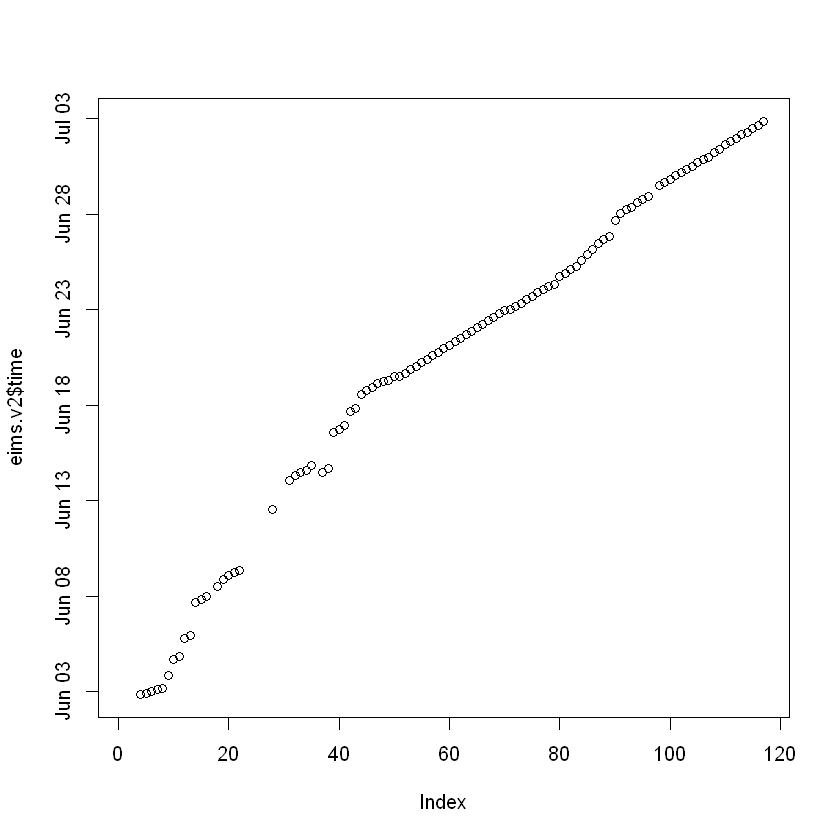

In [15]:
plot(eims.v2$time)

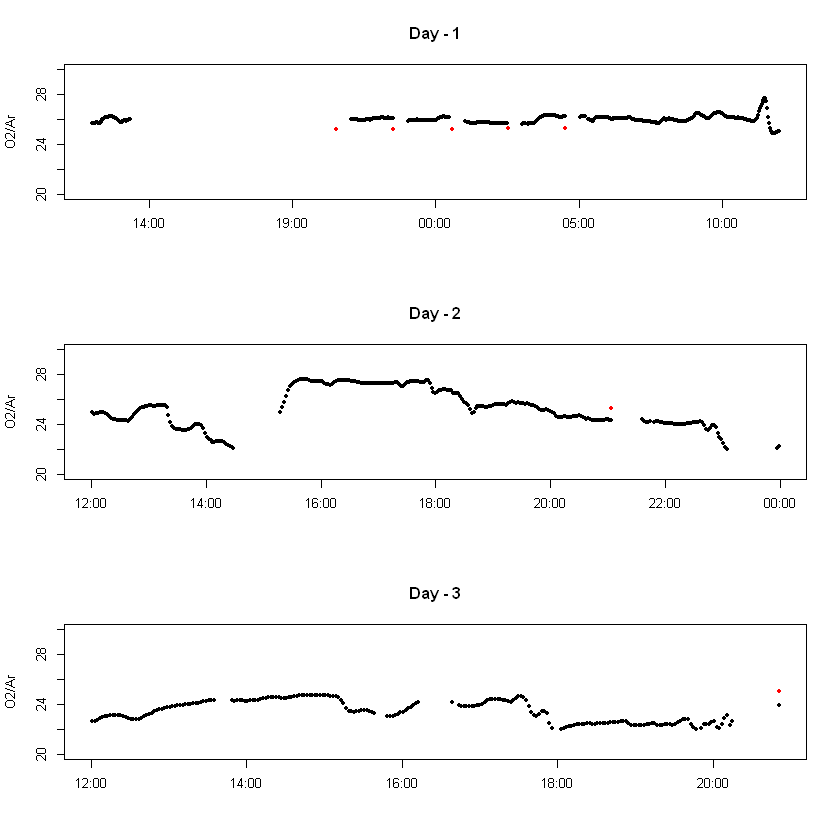

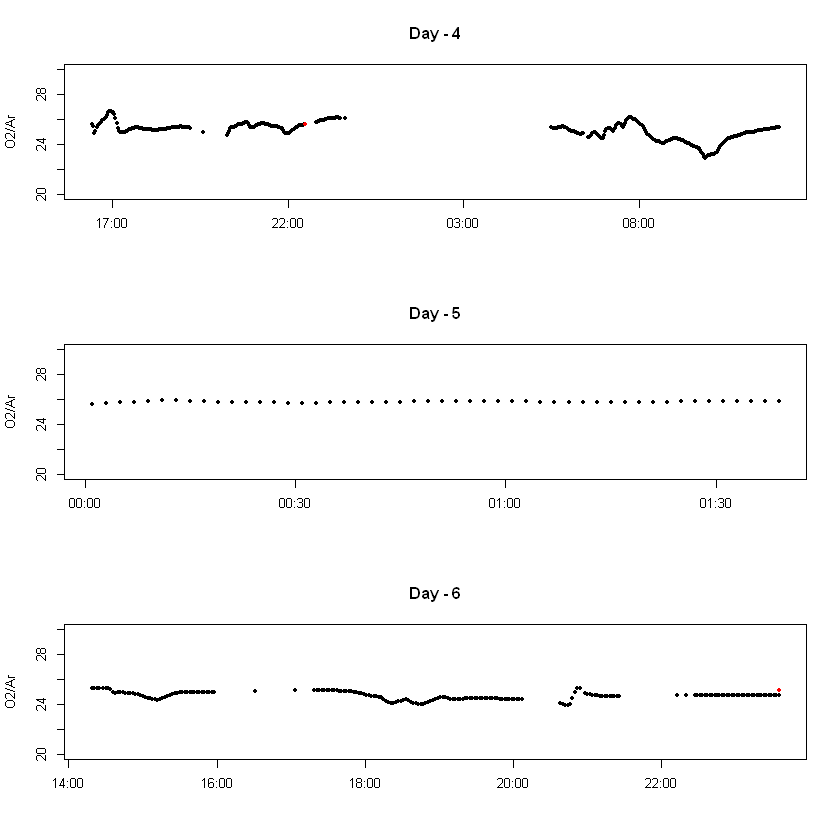

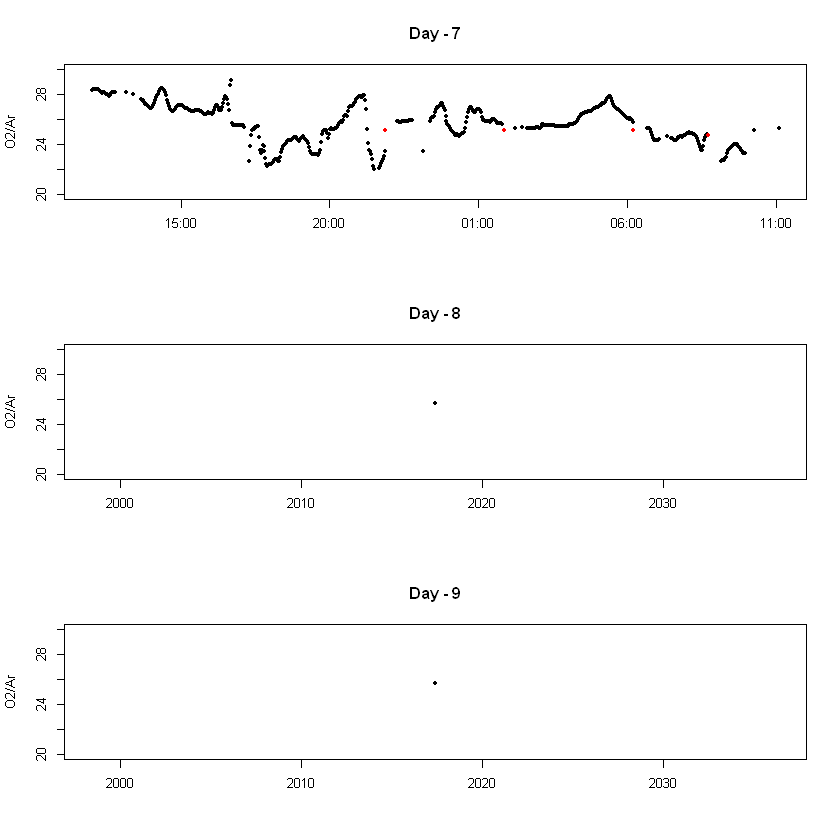

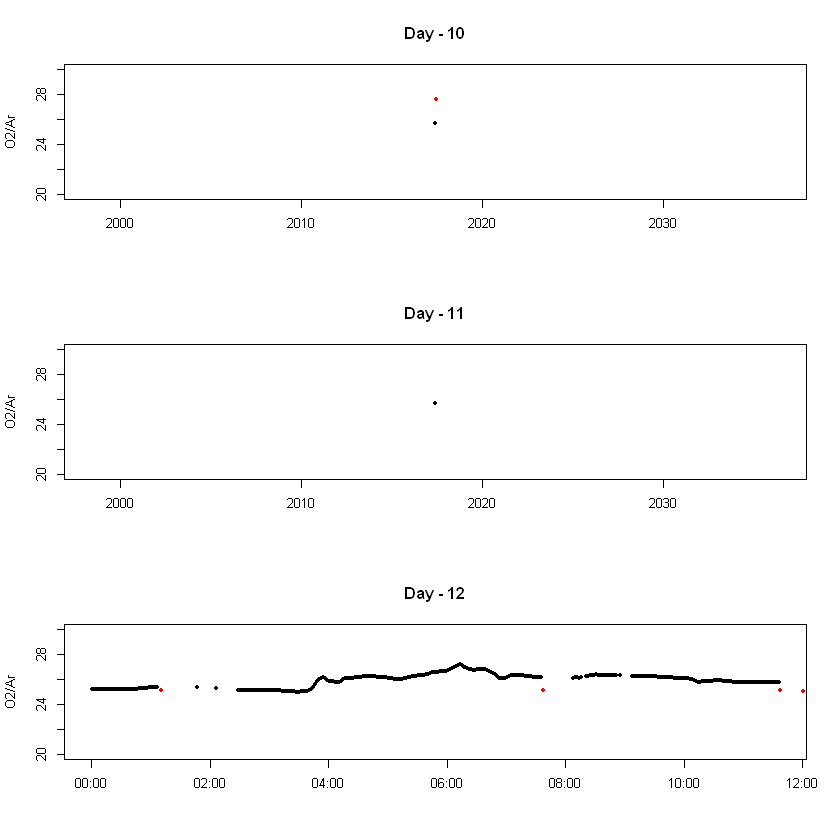

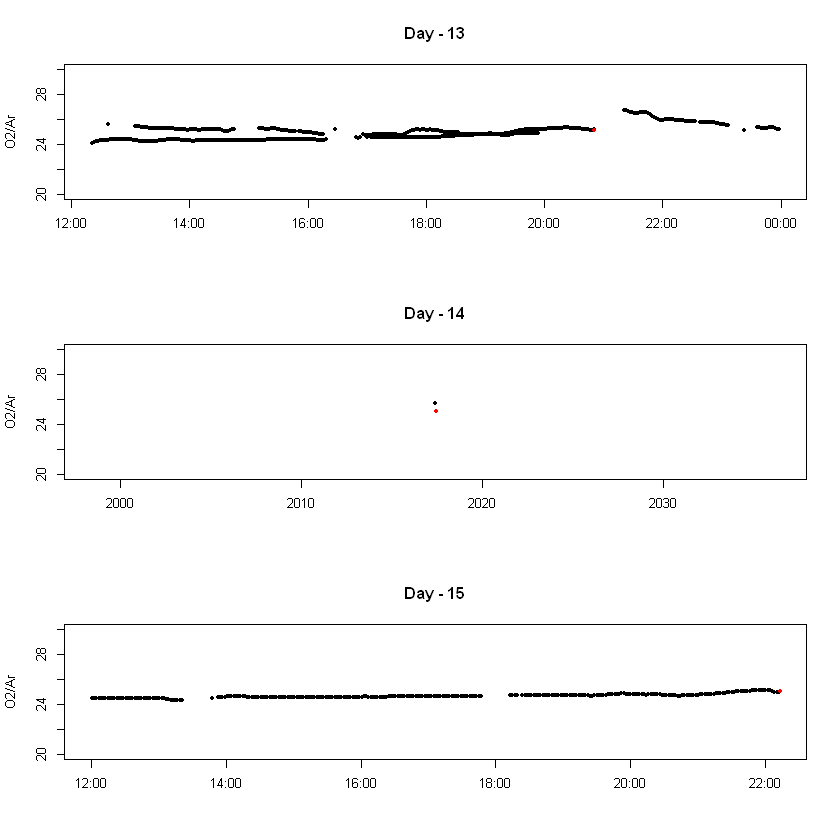

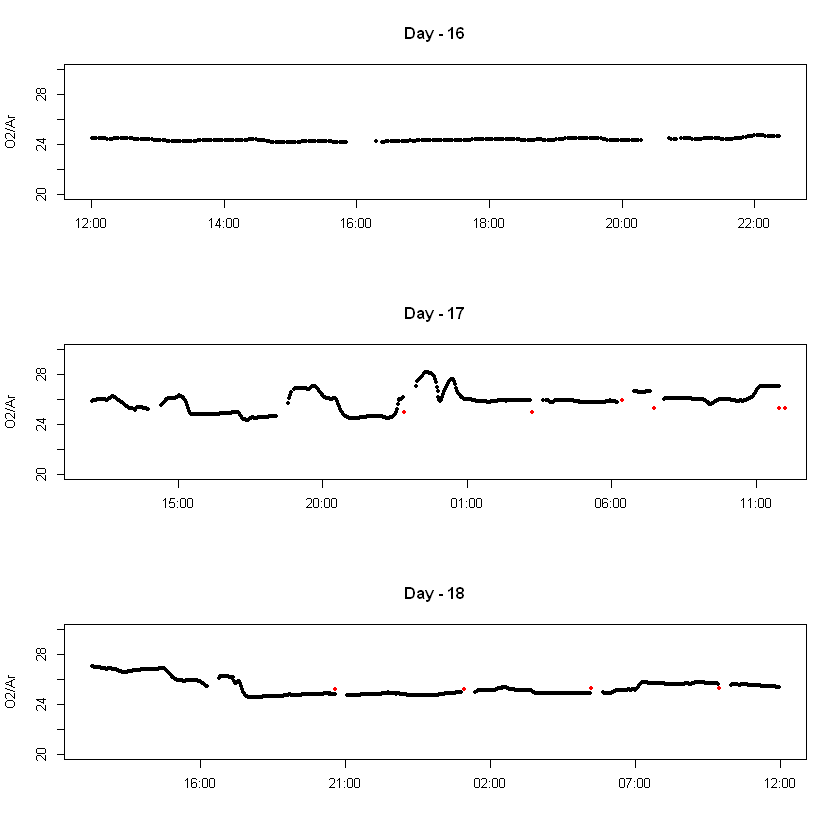

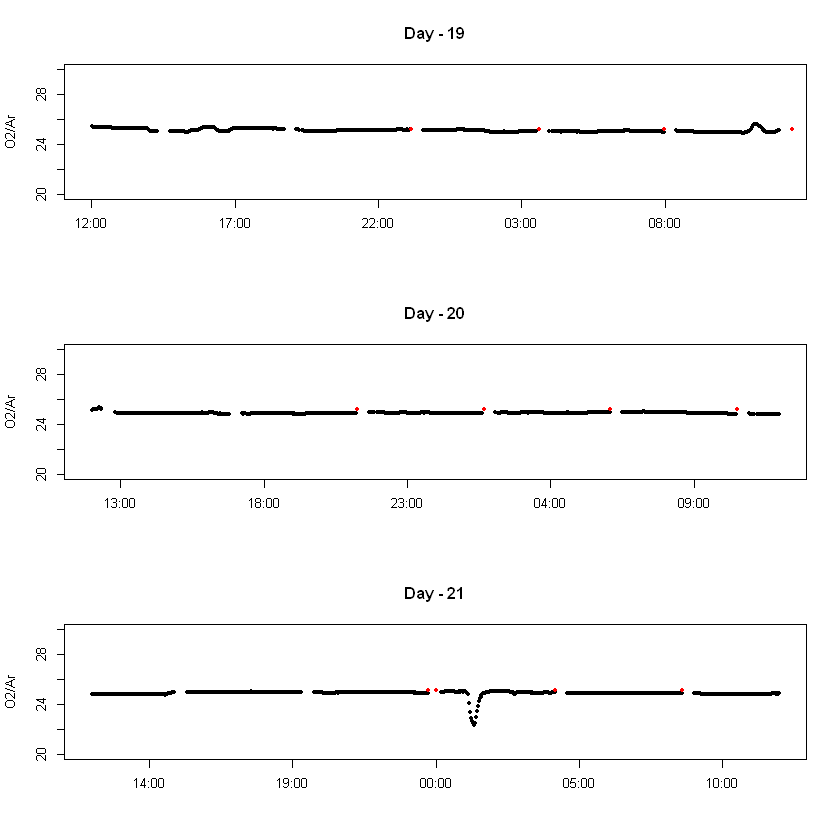

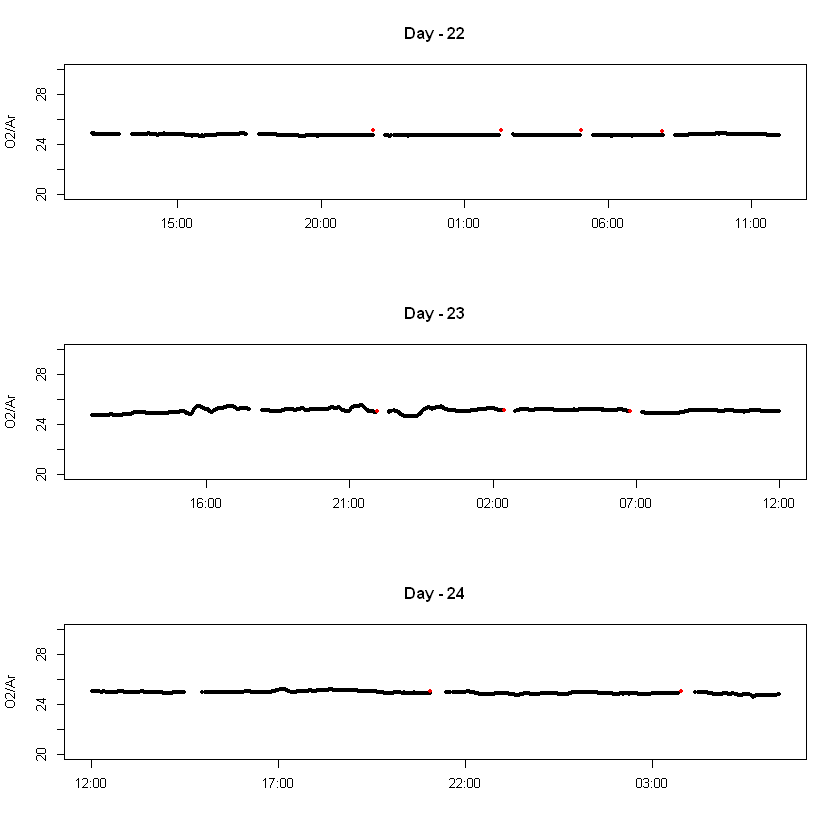

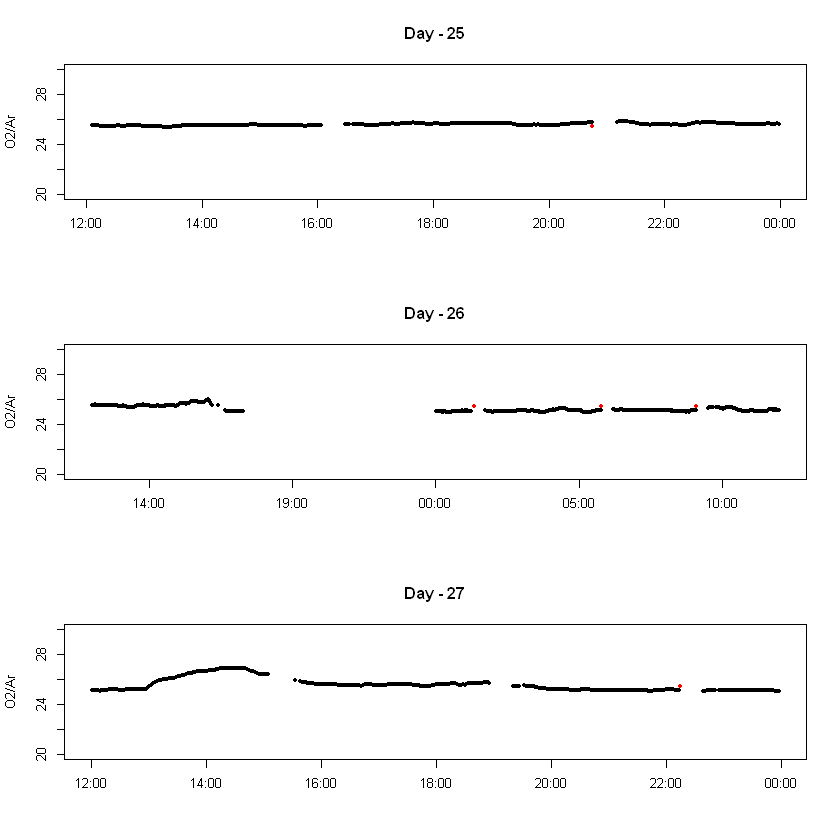

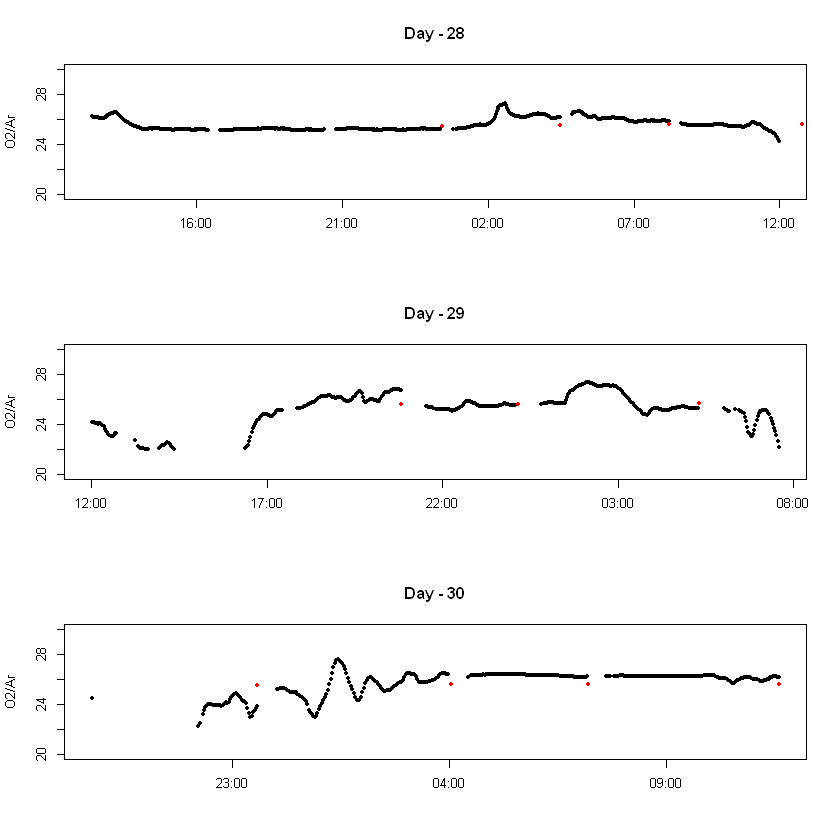

In [16]:
par(mfrow=c(3,1))
#pdf('Output/EIMS-24H Plots.pdf')
eims.v1 = eims.v1[!is.na(eims.v1$time),]
dt = floor(as.numeric(difftime(eims.v1$time, min(eims.v1$time), units='days')))
dt2 = floor(as.numeric(difftime(eims.v2$time, min(eims.v2$time, na.rm = TRUE), units='days')))

for (i in 1:floor(as.numeric(difftime(max(eims.v1$time), min(eims.v1$time), units='days')))) {
    k = which(dt < i & dt >= i-1)
    if(length(k) < 1) {
        k = 1
    }
    k2 = which(dt2 < i & dt2 >= i-1)
    plot(eims.v1$time[k], eims.v1$O2.Ar[k], pch=20, main=paste('Day -', i), xlab='', ylab='O2/Ar', ylim=c(20,30))
    points(eims.v2$time[k2], eims.v2$O2.Ar[k2], pch=20, col='red')
}
#dev.off()

---
# Damaged/Unusable data file recovery

In [ ]:
2

In [100]:
## Create template data structure to add new entries to:
data.v3 = data[1,] # valve = 1
data.v4 = data[1,] # valve = 2

for (i in file.list.nu) {
    ## load file and parse the time
    data = read.csv(paste0(input.dir, i), sep='\t')
    data$time = strptime(data$time, format = dt.format, tz='')
    
    ## determine valve = 1 
    l = which(data$Valve == 1)
    temp = filter.eims(data[l,])
    temp = avg.eims(temp, N)
    
    if (length(names(temp)) == length(names(data.v1))) {
        names(temp) = names(data.v3) # Force colname match (dangerous), but will check that lengths are the same
        data.v3 = rbind(data.v3, temp)
    } else {
        print(i)
    }
    
    ## determine valve = 2
    l = which(data$Valve == 2)
    temp = filter.eims(data[l,])
    temp = avg.eims(temp, N)
    
    if (length(names(temp)) == length(names(data.v4))) {
        names(temp) = names(data.v4) # Force colname match (dangerous), but will check that lengths are the same
        data.v4 = rbind(data.v4, temp)
    } else {
        print(i)
    }
    if (length(data$valve) > 1) {
        print(paste("Lower case Valve issue:", i))
    }
}


## Remove the first row used to initiate the table
data.v3 = data.v3[-1,]
data.v4 = data.v4[-1,]
data.v3 = data.v3[,-c(1, 13, 14, 15, 23, 24, 25)]
data.v4 = data.v4[,-c(1, 13, 14, 15, 23, 24, 25)]

[1] "2017-0603-2102 MID-valve corr not usable 2.txt"
[1] "2017-0603-2102 MID-valve corr not usable.txt"
[1] "2017-0604-0000 MID-valve corr - not usable 2.txt"
[1] "2017-0604-0000 MID-valve corr - not usable.txt"
[1] "2017-0604-0448 MID-valve corr not usable 2.txt"
[1] "2017-0604-0448 MID-valve corr not usable.txt"
[1] "2017-0605-0000 MID-valve corr not usable 2.txt"
[1] "2017-0605-0000 MID-valve corr not usable.txt"
[1] "2017-0605-0407 MID-valve corr - not usable short 2.txt"
[1] "2017-0605-0407 MID-valve corr - not usable short.txt"
[1] "2017-0605-0413 MID-valve corr not usable short 2.txt"
[1] "2017-0605-0413 MID-valve corr not usable short.txt"
[1] "2017-0605-0440 MID-valve corr- not usable 2.txt"
[1] "Lower case Valve issue: 2017-0605-0440 MID-valve corr- not usable 2.txt"
[1] "2017-0605-0440 MID-valve corr- not usable.txt"
[1] "Lower case Valve issue: 2017-0605-0440 MID-valve corr- not usable.txt"
[1] "2017-0606-1200 MID-valve corrnot usable 2.txt"
[1] "2017-0606-1200 MID-valve co